In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import datetime


In [3]:
dataset = pd.read_pickle("/mnt/c/Users/conor/Git_Projects/DOTA/Stats_Data/data_new.pickle").sample(frac=0.1)

In [4]:
dataset.sample(5)

,_id,match_id,radiant_win,account_id0,hero_id0,account_id1,hero_id1,account_id2,hero_id2,account_id3,...,account_id129,hero_id129,account_id130,hero_id130,account_id131,hero_id131,account_id132,hero_id132,Radiant_heros,Dire_heros
623952,5de94b7125b1cadf8e450f52,2043091136,f,4294967295,6,4294967295,65,123757747,62,4294967295,...,100895512,35,4294967295,74,198373546,50,4294967295,8,"[6, 65, 62, 31, 42]","[51, 35, 74, 50, 8]"
579355,5de94b70e77cccaea549541a,2042971798,f,4294967295,27,93257418,13,146713121,82,148798273,...,4294967295,36,4294967295,12,4294967295,101,4294967295,42,"[27, 13, 82, 60, 56]","[76, 36, 12, 101, 42]"
534384,5de94b6fe77cccaea548a46f,2042874272,f,4294967295,104,4294967295,32,94745667,100,4294967295,...,4294967295,88,282150406,81,4294967295,12,4294967295,9,"[104, 32, 100, 18, 86]","[97, 88, 81, 12, 9]"
563529,5de94b70e77cccaea5491648,2042949614,t,4294967295,48,97592716,74,169446569,85,260015343,...,4294967295,12,4294967295,104,128369548,53,4294967295,35,"[48, 74, 85, 7, 106]","[81, 12, 104, 53, 35]"
1369826,5de94b89f53ef546ef43ae34,2305693407,f,4294967295,10,4294967295,1,161035995,56,4294967295,...,267270512,14,4294967295,15,4294967295,104,4294967295,110,"[10, 1, 56, 51, 42]","[66, 14, 15, 104, 110]"


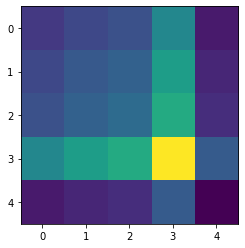

In [5]:
plt.imshow(dataset['Radiant_heros'].iloc[0][None,:]*dataset['Radiant_heros'].iloc[0][:,None])

In [7]:
rh = np.stack(dataset['Radiant_heros'])
dh = np.stack(dataset['Dire_heros'])

In [8]:
def one_hot_heros(h_vect):

    e = np.zeros((h_vect.shape[0], h_vect.max()+1), dtype=np.int)

    for i, row in enumerate(h_vect):

        e[i, row] = 1

    return e


In [9]:
ohr = one_hot_heros(rh)
ohd = one_hot_heros(dh)

In [10]:
heros = pd.DataFrame(np.concatenate([ohr, ohd, dataset.iloc[:,:3]], axis=1))

In [11]:
heros

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,225,226,227,228,229,230
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b60279b6dc43f14907d,2304357266,f
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,5de94b5f279b6dc43f13a7e9,2041688623,f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b9261dbcd4b449c6e4d,2306381350,t
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b84014f24a6ac9dd8ab,2305331876,f
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b87f53ef546ef42ac51,2305557235,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172259,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b78fea43014e2cc0fb8,2304587810,f
172260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b78fea43014e2cc0e05,2043622847,f
172261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b84014f24a6ac9d98c5,2305302745,t
172262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5de94b7f52a9d80617248a4d,2305004268,t


# Autoencoder for heroes

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, losses

In [13]:
latent_dim = 10

class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(80, activation='relu', dtype=np.float64),
      layers.Dense(40, activation='relu', dtype=np.float64),
      layers.Dense(latent_dim, activation='relu', dtype=np.float64),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='relu'),
      layers.Dense(228, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [47]:
x_train, x_test = train_test_split(heros.iloc[:,:-3])

In [50]:
history = autoencoder.fit(x_train.astype(np.int), x_train.astype(np.int),
                epochs=5,
                shuffle=True,
                validation_data=(x_test.astype(np.int), x_test.astype(np.int)))

Epoch 1/5
4038/4038 [==============================] - 17s 4ms/step - loss: 0.0277 - val_loss: 0.0275
Epoch 2/5
4038/4038 [==============================] - 19s 5ms/step - loss: 0.0271 - val_loss: 0.0269
Epoch 3/5
4038/4038 [==============================] - 21s 5ms/step - loss: 0.0267 - val_loss: 0.0264
Epoch 4/5
4038/4038 [==============================] - 21s 5ms/step - loss: 0.0262 - val_loss: 0.0260
Epoch 5/5
4038/4038 [==============================] - 18s 5ms/step - loss: 0.0258 - val_loss: 0.0256


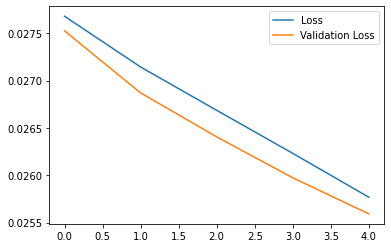

In [52]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

enc = pd.DataFrame(autoencoder.encoder(x_test.astype(np.int).values).numpy())

In [53]:
enc = pd.DataFrame(autoencoder.encoder(heros.iloc[:,:-3].astype(np.int).values).numpy())

In [54]:
dec = pd.DataFrame(autoencoder.decoder(enc.values).numpy())

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, cross_validate

In [68]:
pipe = Pipeline([
    #("Imputer", SimpleImputer()),
    ("Scaler", StandardScaler()),
    ("clf", RandomForestClassifier())
])

In [69]:
idx = np.random.randint(0, heros.shape[0], 10000)

In [72]:
scores = cross_validate(pipe, enc.iloc[idx,:], heros.iloc[idx,-1], cv=5, scoring='roc_auc')

In [73]:
scores

{'fit_time': array([2.90537   , 2.83839154, 2.87863874, 2.81011438, 2.85524106]),
 'score_time': array([0.07313848, 0.06258297, 0.06132936, 0.06197023, 0.0632875 ]),
 'test_score': array([0.55855234, 0.55692955, 0.5544185 , 0.55489021, 0.53926782])}

# Keras

In [60]:
import tensorflow as tf 
import keras

from keras.wrappers.scikit_learn import KerasClassifier

In [61]:
X = dataset.iloc[:,:-2]
y = dataset.loc[:,"Radiant_win"]

KeyError: 'Radiant_win'

Define the model below

In [72]:
def create_model():

    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=X.shape[1]))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(50, activation="relu"))
    model.add(keras.layers.Dense(20, activation="relu"))
    model.add(keras.layers.Dense(5, activation="relu"))
    model.add(keras.layers.Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

    return model

In [73]:
import kerastuner as kt

In [74]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

pipe = Pipeline([
    ("Imputer", SimpleImputer())#,
    #("Scaler", StandardScaler()),
    #("NN", KerasClassifier(build_fn=create_model, epochs=5))
])

y_bin = np.array([1 if i=="t" else 0 for i in y])


preprocessed = pd.DataFrame(pipe.fit_transform(X,y_bin), index=X.index, columns=X.columns)


create_model().fit(x=preprocessed,
y=y_bin,
validation_split=0.3,
epochs=5,
batch_size=32,
callbacks=[tensorboard_callback])

"""
cross_validate(pipe, X, y, scoring="accuracy", cv=5, fit_params={"callbacks":[tensorboard_callback]})
"""

Epoch 1/5
163/163 [==============================] - 1s 5ms/step - loss: 0.6945 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.5020
Epoch 2/5
163/163 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5269 - val_loss: 0.6949 - val_accuracy: 0.4778
Epoch 3/5
163/163 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5238 - val_loss: 0.6950 - val_accuracy: 0.4819
Epoch 4/5
163/163 [==============================] - 1s 3ms/step - loss: 0.6887 - accuracy: 0.5458 - val_loss: 0.6934 - val_accuracy: 0.5029
Epoch 5/5
163/163 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5524 - val_loss: 0.6988 - val_accuracy: 0.5060


'\ncross_validate(pipe, X, y, scoring="accuracy", cv=5, fit_params={"callbacks":[tensorboard_callback]})\n'

In [75]:
%tensorboard --logdir logs


UsageError: Line magic function `%tensorboard` not found.


In [76]:
def create_model(hp):

    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=X.shape[1]))

    n_layers = hp.Int("n_layers", min_value=5,max_value=10)

    for layer_n in range(n_layers):

        n_nodes = hp.Int("n_nodes", min_value=5,max_value=20)
        model.add(keras.layers.Dense(n_nodes, activation="relu"))

    model.add(keras.layers.Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

    return model

In [77]:
tuner = kt.BayesianOptimization(create_model,
                     objective = 'val_accuracy',
                     max_trials = 10,
                     #factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3)

X_train_p = pd.DataFrame(pipe.fit_transform(X_train,y_train), index=X_train.index, columns=X_train.columns)
X_test_p = pd.DataFrame(pipe.fit_transform(X_test,y_test), index=X_test.index, columns=X_test.columns)

In [79]:
tuner.search(X_train_p,
y_train,
epochs=10,
validation_data=(X_test_p, y_test),
callbacks=[tensorboard_callback])


INFO:tensorflow:Oracle triggered exit


In [80]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

tuner.search(preprocessed,
y_bin,
validation_split=0.3,
epochs=5,
batch_size=32,
callbacks=[tensorboard_callback])

INFO:tensorflow:Oracle triggered exit
